In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# be careful with that:
import warnings
warnings.filterwarnings('ignore')

In [21]:
# load data

data_heatmap_t2m = pd.read_csv('A_data_heatmap_300x250_6p_t2m.csv')
data_heatmap_h2m = pd.read_csv('A_data_heatmap_300x250_6p_h2m.csv')

data_heatmap = pd.concat([data_heatmap_t2m, data_heatmap_h2m])
data_heatmap

,Unnamed: 0,domain,grid_id,click_x,click_y,display_height,display_width,clicks,click_x_rel,click_y_rel
0,2000000,ID_2674,333346,62,137,250,300,1,8.0,22.0
1,2000001,ID_2674,333346,66,93,250,300,1,9.0,15.0
2,2000002,ID_2674,333346,249,154,250,300,1,33.0,25.0
3,2000003,ID_2674,333346,86,156,250,300,1,11.0,25.0
4,2000004,ID_2674,333346,71,131,250,300,1,9.0,21.0
...,...,...,...,...,...,...,...,...,...,...
1999995,1999995,ID_2674,333346,43,140,250,300,1,6.0,22.0
1999996,1999996,ID_2674,333346,215,140,250,300,1,29.0,22.0
1999997,1999997,ID_2674,333346,149,129,250,300,1,20.0,21.0
1999998,1999998,ID_2674,333346,228,113,250,300,1,30.0,18.0


In [22]:
# expand so that each row corresponds to 1 click:
data_heatmap_expanded = data_heatmap.loc[data_heatmap.index.repeat(data_heatmap['clicks'])].reset_index(drop=True)
data_heatmap_expanded['clicks'] = 1

click_stat = data_heatmap_expanded.groupby(['click_x','click_y'])['clicks'].count().reset_index()

In [23]:
# Binning clicks in nr_of_x_bins, nr_of_y_bins:

NR_OF_X_BINS = 61
NR_OF_Y_BINS = 51

max_width = data_heatmap['display_width'].max()
max_height = data_heatmap['display_height'].max()

width_bins = np.linspace(1, max_width, NR_OF_X_BINS)
height_bins = np.linspace(1, max_height, NR_OF_Y_BINS)

width_bins_max = len(width_bins)-2 # start at 0
height_bins_max = len(height_bins)-2

data_heatmap_expanded['click_x_bin'] = pd.cut(data_heatmap_expanded['click_x'], 
                                      bins   = width_bins, 
                                      labels = False, 
                                      include_lowest = True)

data_heatmap_expanded['click_y_bin'] = pd.cut(data_heatmap_expanded['click_y'], 
                                      bins = height_bins, 
                                      labels = False, 
                                      include_lowest = True)


aggregated_clicks = data_heatmap_expanded.groupby(['grid_id',
                                           'domain', 
                                           'click_x_bin', 
                                           'click_y_bin']).size().reset_index(name='clicks_sum')


In [24]:
# aggregated clicks by grid_id:

aggregated_clicks_by_grid = aggregated_clicks.groupby([
                                'grid_id','click_x_bin','click_y_bin'
                            ]).sum('clicks_sum').reset_index()

In [25]:
aggregated_clicks_by_grid

,grid_id,click_x_bin,click_y_bin,clicks_sum
0,333346,0,0,1281
1,333346,0,1,1160
2,333346,0,2,597
3,333346,0,3,621
4,333346,0,4,498
...,...,...,...,...
5928,333519,59,45,791
5929,333519,59,46,788
5930,333519,59,47,1044
5931,333519,59,48,1128


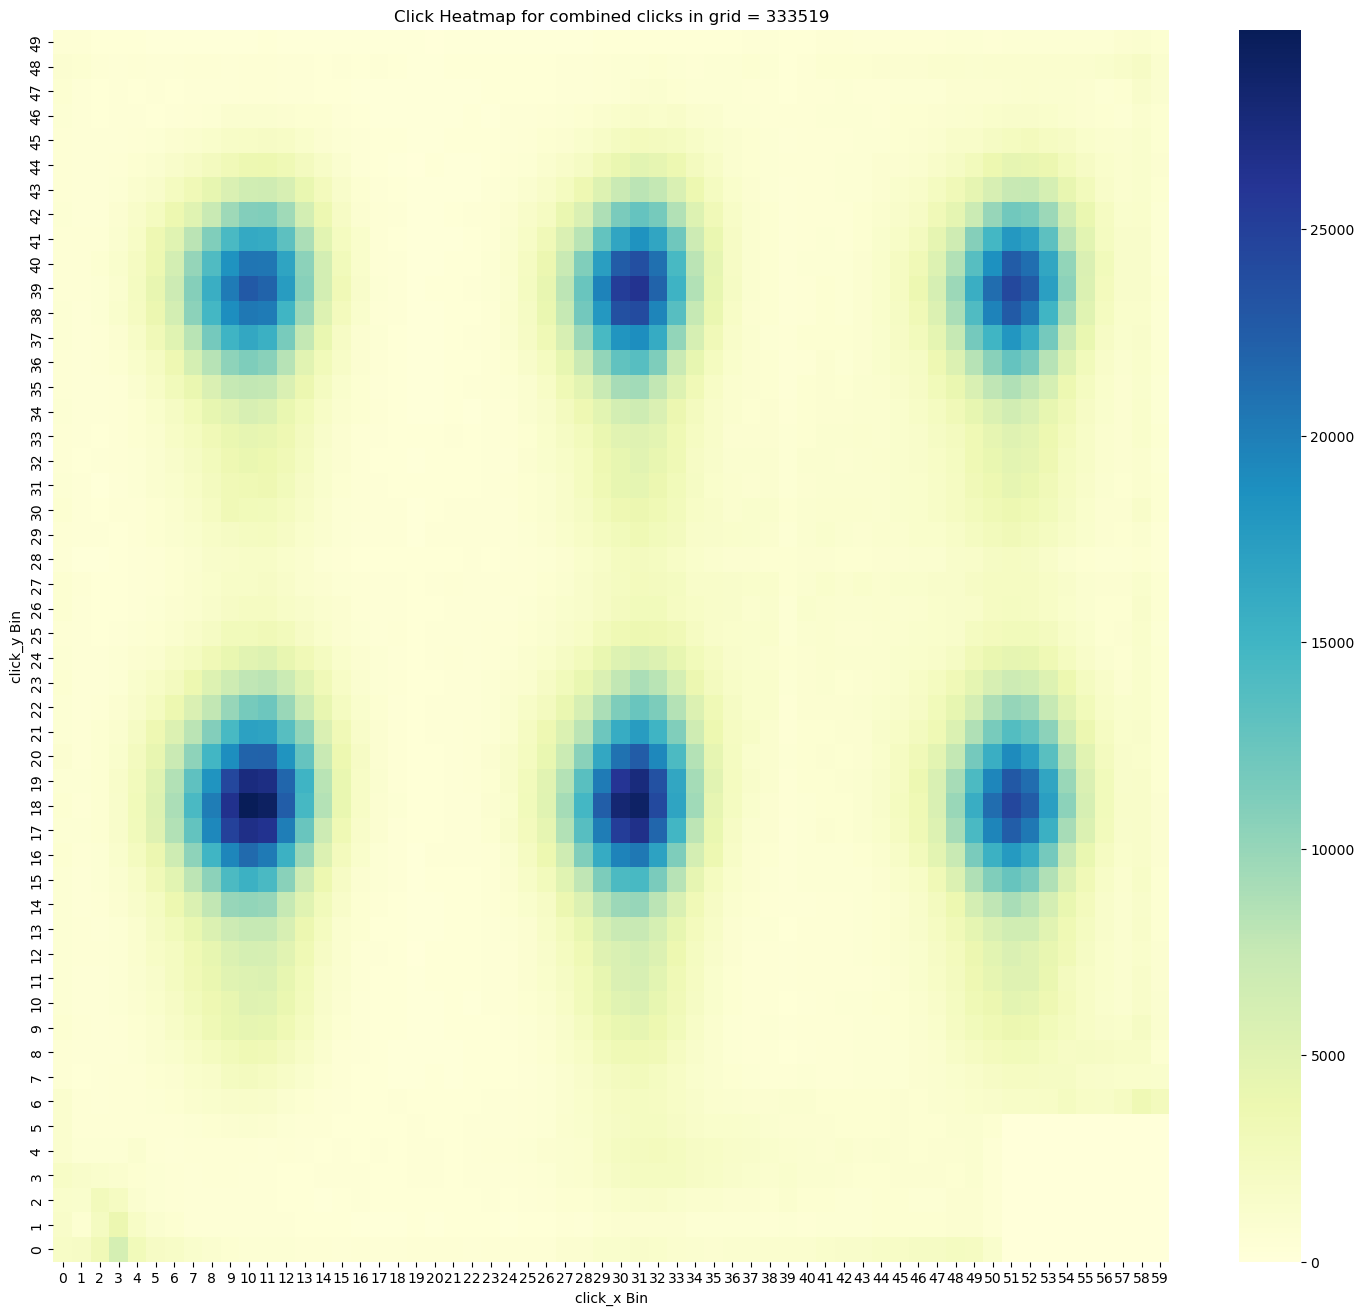

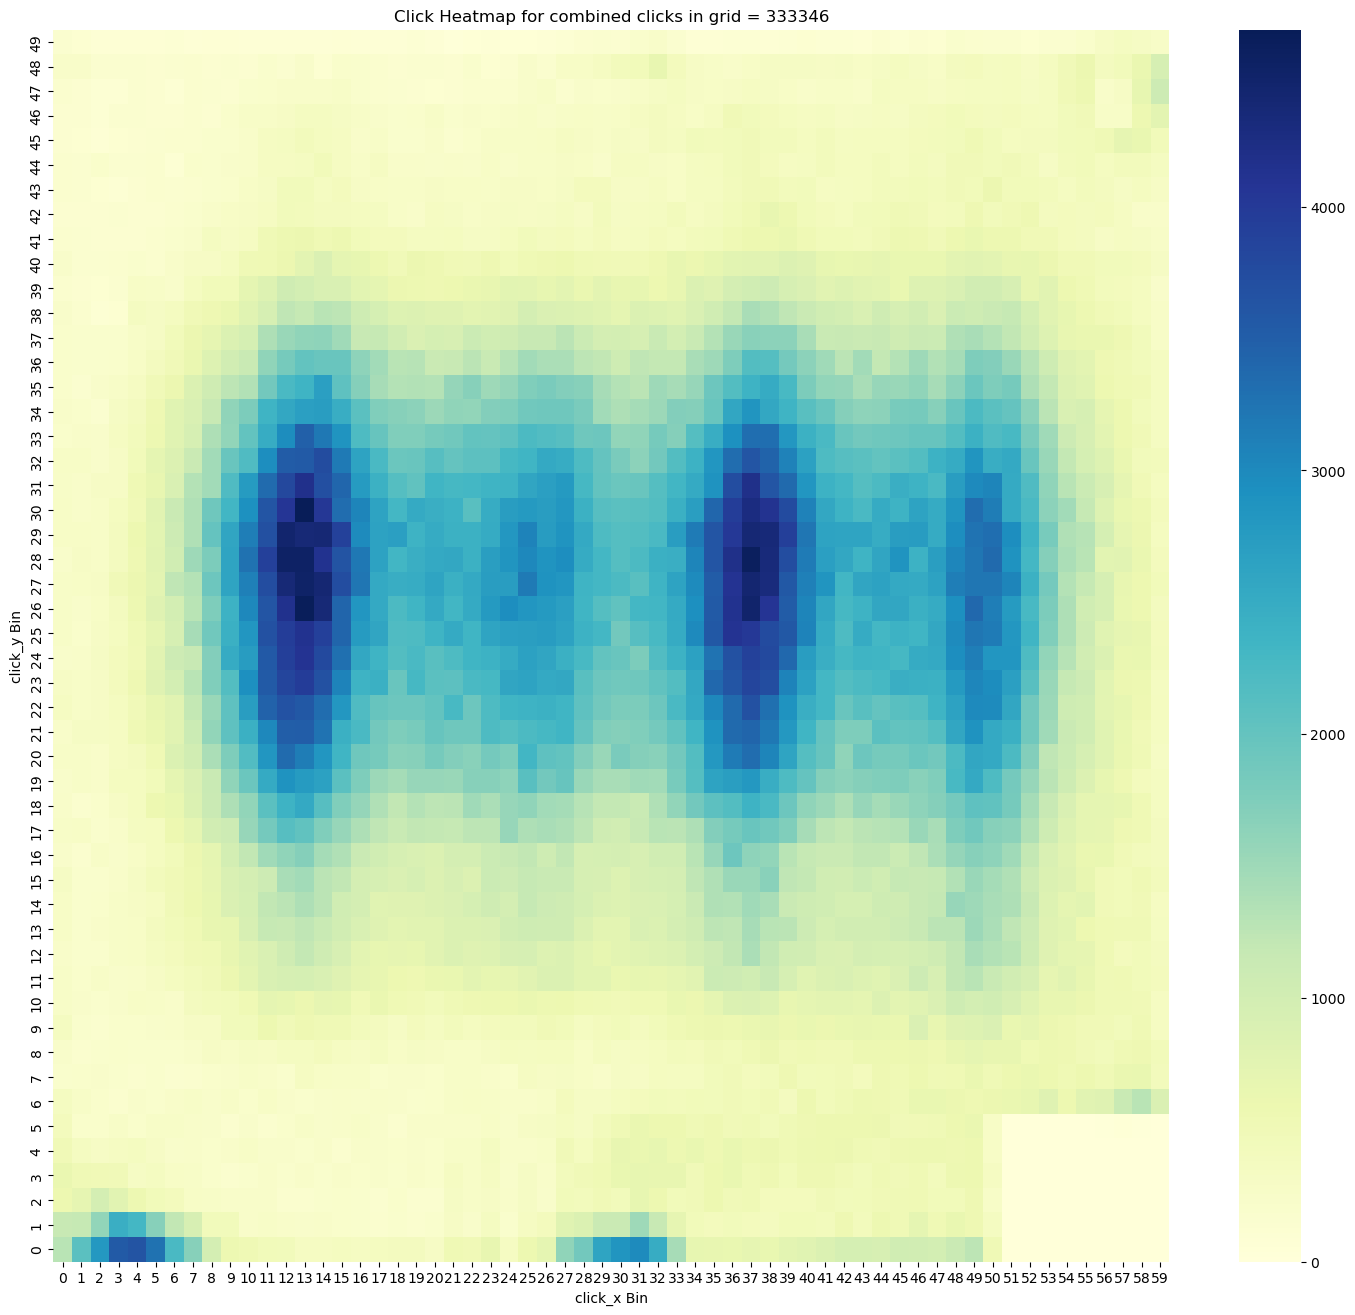

In [26]:
# create aggregated heatmaps:

ex = aggregated_clicks_by_grid[aggregated_clicks_by_grid.grid_id == 333519]

click_matrix = ex.pivot("click_y_bin","click_x_bin", "clicks_sum").fillna(0)

plt.figure(figsize=(18, 16))
sns.heatmap(click_matrix, 
            cmap = "YlGnBu", 
            annot = False, 
            cbar = True, 
            fmt = "g")

plt.title(f'Click Heatmap for combined clicks in grid = {333519}')
plt.xlabel('click_x Bin')
plt.ylabel('click_y Bin')
plt.gca().invert_yaxis() 
plt.savefig('hm_333519.png', bbox_inches='tight')
plt.show()

ex = aggregated_clicks_by_grid[aggregated_clicks_by_grid.grid_id == 333346]

click_matrix = ex.pivot("click_y_bin","click_x_bin", "clicks_sum").fillna(0)

plt.figure(figsize=(18, 16))
sns.heatmap(click_matrix, 
            cmap = "YlGnBu", 
            annot = False, 
            cbar = True, 
            fmt = "g")

plt.title(f'Click Heatmap for combined clicks in grid = {333346}')
plt.xlabel('click_x Bin')
plt.ylabel('click_y Bin')
plt.gca().invert_yaxis() 
plt.savefig('hm_333546.png', bbox_inches='tight')
plt.show()

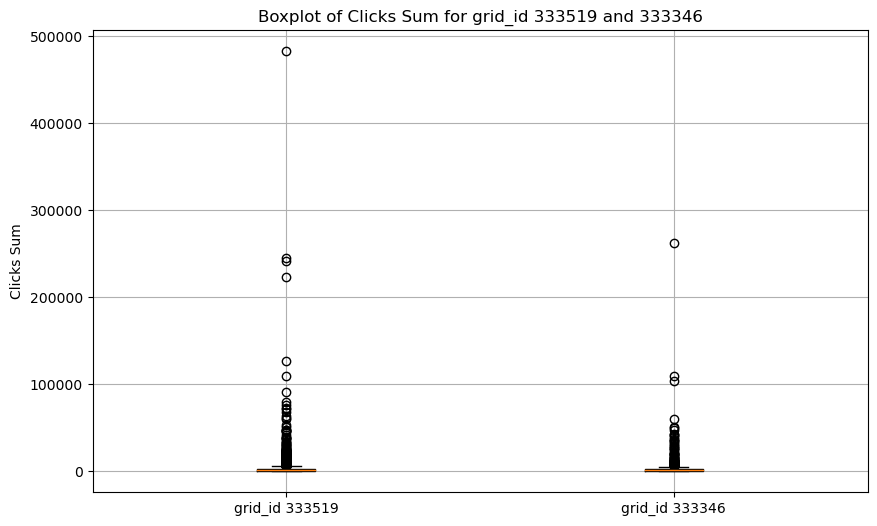

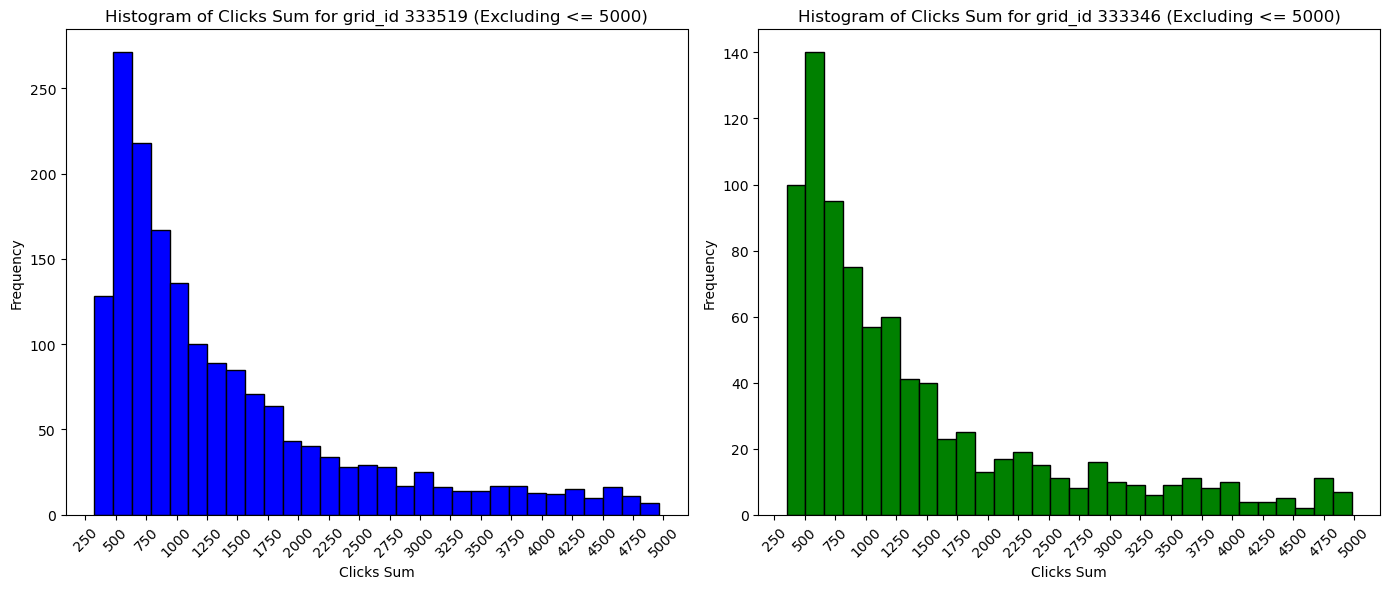

Nr of domains with grid_id 333346 and more than 1k clicks: 545
Percentage of domains with grid_id 333346 and more than 1k clicks: 0.56
Nr of domains with grid_id 333519 and more than 1k clicks: 1232
Percentage of domains with grid_id 333519 and more than 1k clicks: 0.60


In [27]:
# Boxplots and histograms

x = aggregated_clicks.groupby(['domain','grid_id']).sum().reset_index()

data_333519 = x[x.grid_id == 333519]['clicks_sum']
data_333346 = x[x.grid_id == 333346]['clicks_sum']

plt.figure(figsize=(10, 6))
plt.boxplot([data_333519, data_333346], labels=['grid_id 333519', 'grid_id 333346'])
plt.title('Boxplot of Clicks Sum for grid_id 333519 and 333346')
plt.ylabel('Clicks Sum')
plt.grid(True)
#plt.savefig('bp.png', bbox_inches='tight')
plt.show()

data_333519 = x[(x.grid_id == 333519) & (x.clicks_sum <= 5000)]['clicks_sum']
data_333346 = x[(x.grid_id == 333346) & (x.clicks_sum <= 5000)]['clicks_sum']

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(data_333519, bins=30, color='blue', edgecolor='black')
plt.title('Histogram of Clicks Sum for grid_id 333519 (Excluding <= 5000)')
plt.xlabel('Clicks Sum')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  
plt.ticklabel_format(style='plain', axis='x') 
plt.locator_params(axis='x', nbins=24)  

plt.subplot(1, 2, 2)
plt.hist(data_333346, bins=30, color='green', edgecolor='black')
plt.title('Histogram of Clicks Sum for grid_id 333346 (Excluding <= 5000)')
plt.xlabel('Clicks Sum')
plt.ylabel('Frequency')
plt.xticks(rotation=45) 
plt.ticklabel_format(style='plain', axis='x')  
plt.locator_params(axis='x', nbins=24) 

plt.tight_layout()

#plt.savefig('histo.png', bbox_inches='tight')
plt.show()

g_333346_nr_ge1000 = len(x[(x.grid_id == 333346) & (x.clicks_sum > 1000)]['domain'].unique())
pct_333346_nr_ge1000 = g_333346_nr_ge1000/len(x[(x.grid_id == 333346)]['domain'].unique())
print(f'Nr of domains with grid_id {333346} and more than 1k clicks: {g_333346_nr_ge1000}')
print(f'Percentage of domains with grid_id {333346} and more than 1k clicks: {pct_333346_nr_ge1000:.2f}')

g_333519_nr_ge1000 = len(x[(x.grid_id == 333519) & (x.clicks_sum > 1000)]['domain'].unique())
pct_333519_nr_ge1000 = g_333519_nr_ge1000/len(x[(x.grid_id == 333519)]['domain'].unique())
print(f'Nr of domains with grid_id {333519} and more than 1k clicks: {g_333519_nr_ge1000}')
print(f'Percentage of domains with grid_id {333519} and more than 1k clicks: {pct_333519_nr_ge1000:.2f}')

In [ ]:
for (grid_id, domain), group in aggregated_clicks.groupby(['grid_id', 'domain']):
    click_matrix = group.pivot("click_y_bin", "click_x_bin", "clicks_sum").fillna(0)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(click_matrix, cmap="YlGnBu", annot=False, cbar=True, fmt="g")
    plt.title(f'Click Heatmap for grid_id = {grid_id} and domain = {domain}')
    plt.xlabel('click_x Bin')
    plt.ylabel('click_y Bin')
    plt.gca().invert_yaxis() 
    plt.show()